# CIS 5450 Homework 5: Time-Series Machine Learning

### Due April 30th, 2025

Welcome to CIS 5450 Homework 5! In this part of the HW, we will be reviewing time-series models and machine learning methods.

**Grading:** Please note that this HW will be graded as an extra credit for the class.





# Libraries and Setup Jargon [1 point]
Run the following cells to set up the notebook.


Please make sure you enter your **8 digit Penn ID** in the  student ID field below.

In [1]:
%set_env HW_ID=cis5450_sp25_HW5

env: HW_ID=cis5450_sp25_HW5


In [2]:
%%capture
!pip install penngrader-client
!pip install streamparse

In [3]:
%%writefile notebook-config.yaml

grader_api_url: 'https://23whrwph9h.execute-api.us-east-1.amazonaws.com/default/Grader23'
grader_api_key: 'flfkE736fA6Z8GxMDJe2q8Kfk8UDqjsG3GVqOFOa'

Writing notebook-config.yaml


In [4]:
from penngrader.grader import *
import os

# PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY.
# IF NOT, THE AUTOGRADER WON'T KNOW WHO TO ASSIGN POINTS TO YOU IN OUR BACKEND
# YOUR PENN-ID GOES HERE AS AN INTEGER
STUDENT_ID = 73619426

# You should also update this to a unique "secret" just for this homework, to
# authenticate this is YOUR submission
SECRET = "...was asked if i was running in the relay, funny..."

In [5]:
grader = PennGrader('notebook-config.yaml', os.environ['HW_ID'], STUDENT_ID, SECRET)

PennGrader initialized with Student ID: 73619426

Make sure this correct or we will not be able to store your grade


## Import the required Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, TensorDataset
from collections import Counter
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import time
# import streamparse
import statsmodels as st

# Part 0: Set up GPU capabilities [0 points]

The cell below sets up a CUDA device to use with torch, if available to you.

**Remember to turn on the GPU for runtime in Colab**
*   Go to Runtime -> Change runtime type --> GPU


Note that you can create a PyTorch tensor `T` that resides on the GPU using the command `T = torch.Tensor(..., device=cuda)`.
You can also copy existing tensors to the GPU with the command `T = T.to(device)` (make sure to overwrite `T` with the result of this function call). If you do not have a GPU, these commands will still work.

**NOTE**: The grader cell below is to check that you are using the GPU, since it is beneficial in later sections that require parallel computation on arrays (i.e., Section 2). Otherwise, model training will take a very long time, especially for the neural networks-based models.

In [7]:
# DO NOT MODIFY
torch.manual_seed(42) # For grading consistency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.6.0+cu124
cuda:0


In [8]:
device

device(type='cuda', index=0)

# **Part 1:** Time-Series Modelling in Python [10 points]

In this section, you will gain exposure to traditional time-series regression models. Let's get started!

## 1.1: Loading the Dataset [0 points]

In this notebook, we will use a dataset on stock prices for FAANG companies from 2000 to the current day. In this step, we will load the data and perform some basic preprocessing in Python.

In [9]:
faang_df = pd.read_csv('https://storage.googleapis.com/penn-cis5450/faang.csv')

## 1.2: EDA [1 point]

Now that we have imported and preprocessed our data, we will perform some EDA to learn a little bit more about our data.

If there are any null values, remove them here.

In [10]:
faang_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31536 entries, 0 to 31535
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  31536 non-null  int64  
 1   Date        31536 non-null  object 
 2   Ticker      31536 non-null  object 
 3   Open        31536 non-null  float64
 4   High        31536 non-null  float64
 5   Low         31536 non-null  float64
 6   Close       31536 non-null  float64
 7   Adj Close   31536 non-null  float64
 8   Volume      31536 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 2.2+ MB


In [11]:
faang_df.head()

,Unnamed: 0,Date,Ticker,Open,High,Low,Close,Adj Close,Volume
0,106288,2004-08-19,GOOGL,2.502503,2.604104,2.401401,2.511011,2.504808,893181924
1,106289,2004-08-20,GOOGL,2.527778,2.729730,2.515015,2.710460,2.703765,456686856
2,106290,2004-08-23,GOOGL,2.771522,2.839840,2.728979,2.737738,2.730976,365122512
3,106291,2004-08-24,GOOGL,2.783784,2.792793,2.591842,2.624374,2.617892,304946748
4,106292,2004-08-25,GOOGL,2.626627,2.702703,2.599600,2.652653,2.646101,183772044


**TODO:** Convert the `Date` column to `datetime` to allow for future operations to be carried on the dates.

In [10]:
# TODO: convert the date column to date time
faang_df['Date'] = pd.to_datetime(faang_df['Date'])

In [11]:
# Grader Cell
grader.grade(test_case_id = "date_conversion", answer = faang_df)

Correct! You earned 1/1 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 1.2.1 Plot the stock price of each ticker over time [3 manually graded points]

Now, we will examine how the closing price of each stock has changed over the years.

**TODO**

- Aggregate the average closing price for every month and year combo for each ticker.
- For each faang ticker `['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']` plot the average closing price per month/year.
- Include an x-axis tick for each year
- Remember to label your axes and give each graph a title

Note that some companies have data for different years than others.

In [12]:
faang_tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']

# TODO: Aggregate data by month and year
import matplotlib.pyplot as plt
import seaborn as sns

# Create year and month columns
faang_df['Year'] = faang_df['Date'].dt.year
faang_df['Month'] = faang_df['Date'].dt.month

# Group by Ticker, Year, Month and compute average Close
monthly_avg = faang_df.groupby(['Ticker', 'Year', 'Month'])['Close'].mean().reset_index()

# Create a new datetime column for plotting (use first day of month for simplicity)
monthly_avg['YearMonth'] = pd.to_datetime(monthly_avg[['Year', 'Month']].assign(DAY=1))


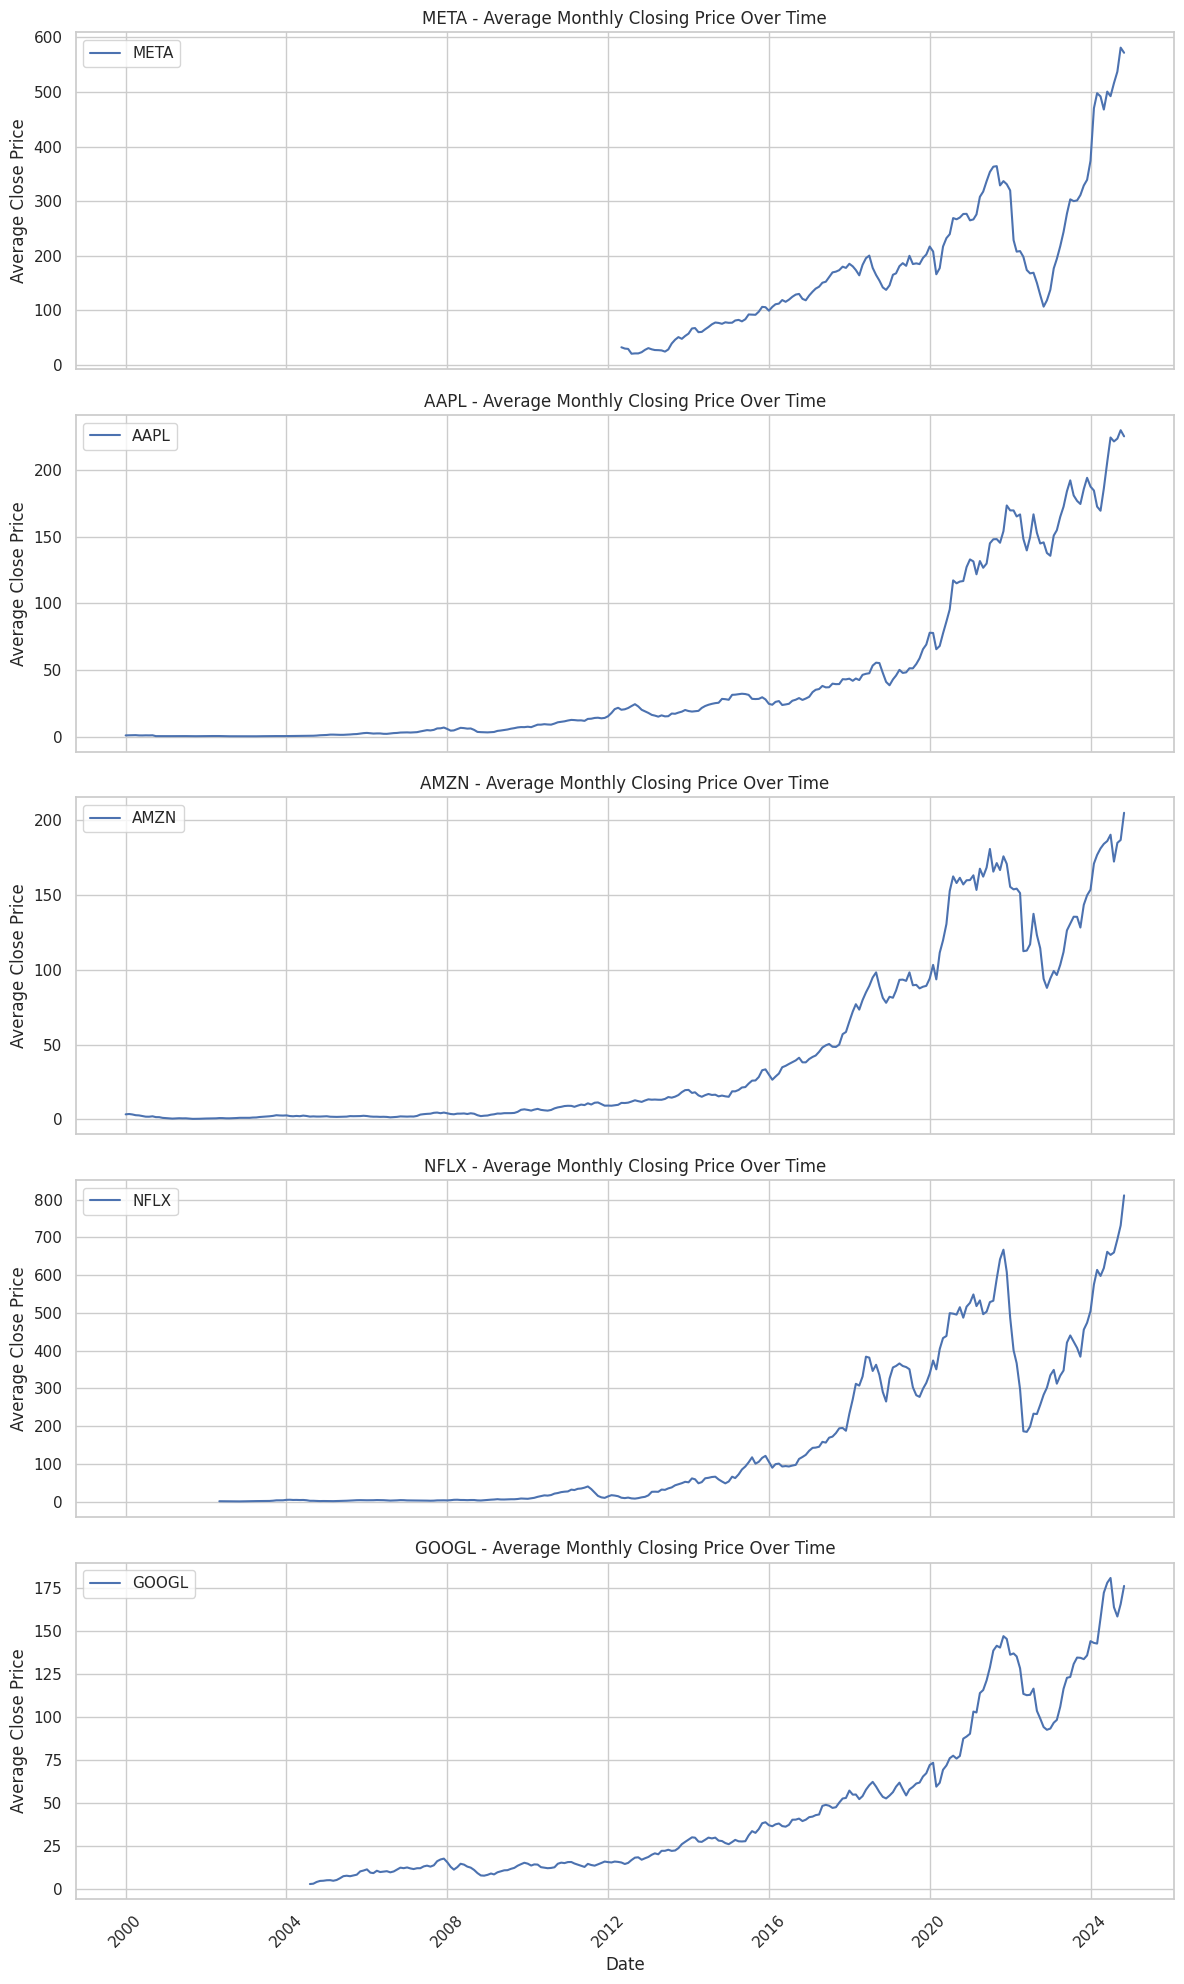

In [15]:
# TODO: Plot each company ticker
# Set plotting style
sns.set(style="whitegrid")

# Plotting
faang_tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
fig, axes = plt.subplots(len(faang_tickers), 1, figsize=(12, 20), sharex=True)

for i, ticker in enumerate(faang_tickers):
    data = monthly_avg[monthly_avg['Ticker'] == ticker]
    axes[i].plot(data['YearMonth'], data['Close'], label=ticker)
    axes[i].set_title(f'{ticker} - Average Monthly Closing Price Over Time')
    axes[i].set_ylabel('Average Close Price')
    axes[i].legend()
    axes[i].grid(True)

axes[-1].set_xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 1.3: Moving Average Model

Now that we have finished our EDA, we will begin fitting models to our data. We will aim to forecast `'AAPL'` stock prices (`'close'`) from this point onwards - please keep this in mind thoughout the remaining parts.

The first model we will apply to this model is a simple moving average model.

### 1.3.1: Define Moving Average Model Class [2 points]

**TODO:** In this exercise, you will complete the `MovingAverage` class. Complete the constructor below. Your final model should take in $q$, or the number of terms to consider in the moving average. The method `fit_transform` should take in target variable (time-series variable) `x`, and output the predictions returned based on your model architecture.

**Hint 1:** To debug your model, we recommend writing a few test cases as a sanity check.

**Hint 2:** What do you think the moving average model should do when there are not enough examples to average, especially during the initial steps? Can we use the mean\ of all available previous elements for the first few time steps?

In [13]:
class MovingAverage:
  def __init__(self, q):
    ## TODO: Complete __init__ method
    self.q = q

  def fit_transform(self, x):
    ## TODO: Complete fit_transform method to return predictions returned by the model
    preds = []

    for i in range(len(x)):
          if i < self.q:
              # Not enough elements behind, so use the mean of available ones
              preds.append(np.mean(x[:i]) if i > 0 else 0)
          else:
              # Average of previous q elements
              preds.append(np.mean(x[i - self.q:i]))

    return np.array(preds)

In [14]:
print(MovingAverage(4).fit_transform(np.arange(7)))

[0.  0.  0.5 1.  1.5 2.5 3.5]


In [15]:
## Grader Cell - ? Points
model = MovingAverage(4)
grader.grade(test_case_id = "ma_architecture", answer = model.fit_transform(np.arange(7)))
# Will take in MA class and test it on our own data

You earned 3/4 points.

Double-check what your code does when the number of inputs in the window is less than q.
Don't worry, you can re-submit and we will keep only your latest score.


### 1.3.2: Fit Moving Average Models to Data [2 points]

**TODO:** The next step is to fit the moving average models to your data. Fit five MA models trying different values of q from the list `[1, 10, 100, 1000, 5000]`, and compute the mean squared error between your moving average models and the actual ground truth data.


In [16]:
apple_df = faang_df[faang_df["Ticker"] == "AAPL"]
apple_close = apple_df["Close"]

In [17]:
## TODO: Fit MA models
from sklearn.metrics import mean_squared_error

# Focus on AAPL data
apple_df = faang_df[faang_df["Ticker"] == "AAPL"].copy()
apple_close = apple_df["Close"].values

# Values of q to test
q_values = [1, 10, 100, 1000, 5000]

# Store MSE results
mse_results = {}

# Fit and evaluate each model
for q in q_values:
    model = MovingAverage(q)
    preds = model.fit_transform(apple_close)
    mse = mean_squared_error(apple_close, preds)
    mse_results[q] = mse
    print(f"q={q}, MSE={mse:.4f}")

q=1, MSE=1.5375
q=10, MSE=5.4912
q=100, MSE=46.5399
q=1000, MSE=676.2249
q=5000, MSE=3271.0138


In [18]:
## Grader Cell - ? Points
grader.grade(test_case_id = "ma_fit", answer = mse)
# Compares MSE values to our own - may want to allow some degree of leniency

Error: Test case failed. Test case function could not complete due to an error in your answer.
Error Hint: 'float' object is not subscriptable


### 1.3.3: Plot Moving Average Models [2 manually graded points]

**TODO:** Finally, plot on the same axis a line of your moving average model fits and the actual values in the time-series. Remember to include an axis title, labels, and legend in your plot, and to color code each of your models.

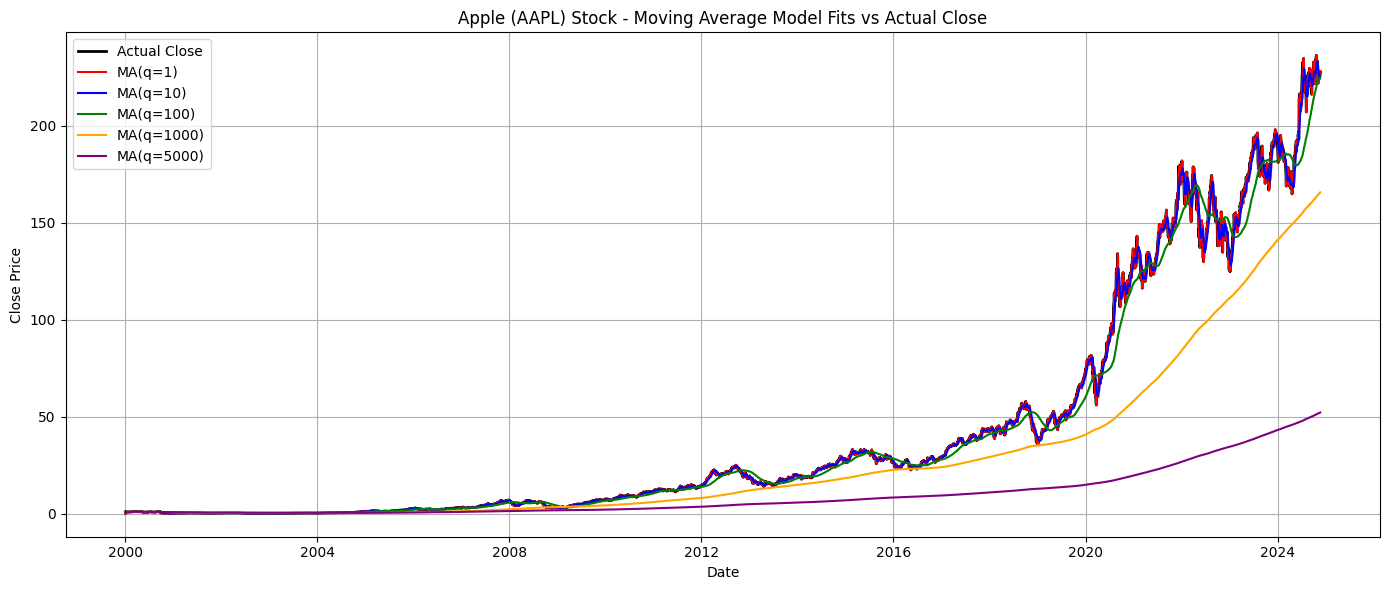

In [19]:
## TODO: Plot Moving Average Models
# Set up the figure
plt.figure(figsize=(14, 6))

# Plot actual data
plt.plot(apple_df['Date'], apple_close, label='Actual Close', color='black', linewidth=2)

# Plot predictions for each q
colors = ['red', 'blue', 'green', 'orange', 'purple']
q_values = [1, 10, 100, 1000, 5000]

for q, color in zip(q_values, colors):
    model = MovingAverage(q)
    preds = model.fit_transform(apple_close)
    plt.plot(apple_df['Date'], preds, label=f'MA(q={q})', color=color)

# Labeling and aesthetics
plt.title('Apple (AAPL) Stock - Moving Average Model Fits vs Actual Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Part 2:** Time-Series Machine Learning in Python [30 points]

Previously, we explored some traditional methods of time-series modelling. There are also a few other model types (such as exponential smoothing and Holt's Method), which we will not cover in this exercise. However, in this section, we will seek to apply machine learning methods to fit to our time-series data.

## 2.1: Loading our Data in `PyTorch` [5 points]

**TODOs:**
- Follow the TODOs below to prepare the `X` and `y` features for your model training:
 - Complete the `prepare_data` method to preprocess our data to input into our machine learning methods.
 - Define DataLoaders to feed into our machine learning algorithms using the `prepare_data` method.
 - Make sure to configure the `prepare_data` method to output tensors for both the train and test split! Specifically, you should do a **80% - 20% split**.

**Notes/Hints:**
- Remember - we will only be performing the prediction for the `'AAPL'` ticker.
- If you get stuck, imagine a sliding window of `sequence_length`:
 - `X` should be a tensor where each element is a particular sliding window (elements `i` to `i+sequence_length`) of the close prices. That is, `X` should be a tensor of tensors, each of length `sequence_length`.
 - `y` is a tensor where each element is the singular closing price of the point right after the sliding window of the corresponding `X` (element `sequence_length+i`).
- If you are confused by the idea of a sliding window in this section, remember the context in which we are applying machine learning - at each period of time, we are limiting the machine learning algorithm to only have access to a few previous data points (which are captured by the sliding window). These functions will help us to do this.

In [20]:
from sklearn.preprocessing import MinMaxScaler

def prepare_data(data, ticker, sequence_length):

    '''
    Inputs:
    data - input dataframe
    ticker - string representing the ticker we want to predict on
    sequence_length - integer representing length of the sliding window

    Outputs:
    X_train - tensor of "slices" captured by the sliding window for train set
    y_train - tensor of ground truth values for each time index for train set
    X_test - tensor of "slices" captured by the sliding window for test set
    y_test - tensor of ground truth values for each time index for test set
    scaler - fitted MinMaxScaler to the close prices
    '''
    # TODO: Filter data for the given ticker

    # TODO: apply a MinMaxScaler on the 'Close' prices

    # TODO: Create X and y sequences

    # TODO: return X (tensor), y (tensor), and the scaler

    '''
    Prepares sliding-window sequences for ML modeling on time-series data.

    Returns:
    - X_train, y_train, X_test, y_test: Tensors for training and testing
    - scaler: fitted MinMaxScaler object
    '''
    # Filter data for the specified ticker
    ticker_df = data[data['Ticker'] == ticker].copy()
    close_prices = ticker_df['Close'].values.reshape(-1, 1)

    # 2. Scale the entire close price series
    scaler = MinMaxScaler()
    scaled_close = scaler.fit_transform(close_prices)

    # 3. Split scaled series first into train and test (before making windows)
    split_index = int(len(scaled_close) * 0.8)
    train_series = scaled_close[:split_index]
    test_series = scaled_close[split_index:]

    # 4. Helper to create windows
    def create_sequences(series):
        X, y = [], []
        for i in range(len(series) - sequence_length):
            X.append(series[i:i + sequence_length])
            y.append(series[i + sequence_length])
        return np.array(X), np.array(y)

    # 5. Create X/y for both train and test
    X_train, y_train = create_sequences(train_series)
    X_test, y_test = create_sequences(test_series)

    # 6. Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    return X_train, y_train, X_test, y_test, scaler


In [32]:
# Pass data in your prepare_data function
sequence_length = 500 #DO NOT CHANGE
ticker = 'AAPL'
X_train, y_train, X_test, y_test, scaler = prepare_data(faang_df, ticker, sequence_length)

In [33]:
# TODO: Create DataLoaders (hint: pass in a TensorDataset of the X and y values into your DataLoader)
# HINT: make sure that you are NOT shuffling your data (why?)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders — NO shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [34]:
len(X_train), len(y_train), len(X_test), len(y_test)

(4509, 4509, 753, 753)

In [35]:
# Grader Cell - 5 Points
# DO NOT EDIT ANYTHING
trainLoaderCheck = [getattr(train_loader, "batch_size"),
                    str(type(train_loader)),]
testLoaderCheck = [getattr(test_loader, "batch_size"),
                    str(type(test_loader)),]
grader.grade(test_case_id = "data_prep", answer = (len(X_train), len(y_train), len(X_test), len(y_test), trainLoaderCheck, testLoaderCheck))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## 2.2: Recurrent Neural Network (RNN)

RNNs are neural networks trained on sequential data (ex: time series data or sequence of words). It is great at capturing temporal relationships. Using the past sequence, it can predict future values, making it a suitable model for forecasting.


Below, we have an example of an RNN architecture. It has multiple hidden layers, as well as an output layer.
Unlike a FCN, an RNN model shares the parameters across different layers. This allows the weights (U) to learn the data in a sequential way by remembering data from previous steps.

At each step, an output y is generated. During backpropagation, this model will calculate the loss of the predicted output at each time step versus the actual output.

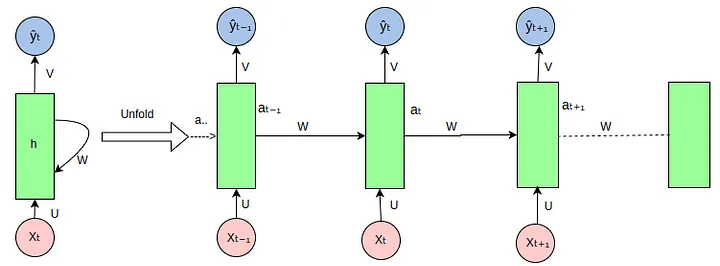

### 2.2.1: Define RNN Architecture in `PyTorch` [5 points]

**TODOs:** Now, you will implement this RNN architecture in `PyTorch`.
- Follow the TODOs below and define an RNN model class.
- You may also refer to the figure above and the `PyTorch` documentation for guidance.


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # TODO: Define stacked RNN layers (see nn.RNN)

        # TODO: Define a fully connected layer


    def forward(self, x, hidden=None):
        # Initialize hidden state of zeros if it doesn't exist
        if hidden is None:
            hidden = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass x and the hidden state through RNN layer
        out, hidden = self.rnn(x, hidden)

        # Pass the last output of the sequence to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out, hidden

In [36]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define stacked RNN layers
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Define a fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        # Initialize hidden state of zeros if it doesn't exist
        if hidden is None:
            hidden = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass x and the hidden state through RNN layer
        out, hidden = self.rnn(x, hidden)

        # Pass the last output of the sequence to the fully connected layer
        out = self.fc(out[:, -1, :])  # out[:, -1, :] gets the last time step output
        return out, hidden

In [37]:
# TODO: come up with relevant hyperparameters
input_size = 1      # Since we're using univariate time series data (Close price)
hidden_size = 64    # Arbitrary, can be tuned
output_size = 1     # We're predicting a single value, the next closing price
num_layers = 2      # You can experiment with more layers for better learning

# Instantiate the model
model = RNN(input_size, hidden_size, output_size, num_layers)

# Print the model architecture
print(model)

RNN(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [38]:
# Grader Cell - 5 Points
grader.grade('define_rnn', answer = (str(model), input_size, hidden_size, output_size, num_layers))

Correct! You earned 5.0/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2.2: Fit/train RNN Model [3 points]

Excellent - now that the RNN model has been defined, let's train it on our model.

**TODO:** Complete the `train_model` function, which defines a training loop for us to use in the subsequent parts.

**Hints:**
* If you are still confused on training loops, we encourage you to refer to your code for the HW 5 main path. Note that even though we have changed the model architecture from an FCN/CNN to an RNN, `Pytorch` provides the same framework for training all of these algorithms, so we can use a very similarly-structured training loop.
* You will need to decide on appropriate parameters for the model. If you are getting a very poor loss value/losing points on the autograder, consider changing your model parameters.

In [39]:
# set seed
torch.manual_seed(42)

In [40]:
def train_model(model, train_loader, criterion, optimizer, epochs=20):
    '''
    Inputs:
    - model: instantiated machine learning model to be trained
    - train_loader: DataLoader object containing training data for the model
    - criterion: loss criterion on which to train the model on
    - optimizer: PyTorch optimizer object
    - epochs: number of epochs
    '''
    loss_list = []
    model = model.to(device)
    criterion = criterion.to(device)
    model.train()
    # TODO: Implement the training loop - including printouts for each epoch's loss value

    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            output, hidden = model(X_batch)

            # Compute loss
            loss = criterion(output, y_batch)
            running_loss += loss.item()

            # Backward pass
            loss.backward()

            # Optimizer step (update model weights)
            optimizer.step()

        # Track loss for each epoch
        avg_loss = running_loss / len(train_loader)
        loss_list.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return loss_list


# 4. Initialize and train the model above (not a TODO)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

loss_list = train_model(model, train_loader, criterion, optimizer)

Epoch [1/20], Loss: 0.0012
Epoch [2/20], Loss: 0.0021
Epoch [3/20], Loss: 0.0026
Epoch [4/20], Loss: 0.0027
Epoch [5/20], Loss: 0.0027
Epoch [6/20], Loss: 0.0027
Epoch [7/20], Loss: 0.0027
Epoch [8/20], Loss: 0.0026
Epoch [9/20], Loss: 0.0024
Epoch [10/20], Loss: 0.0022
Epoch [11/20], Loss: 0.0020
Epoch [12/20], Loss: 0.0017
Epoch [13/20], Loss: 0.0014
Epoch [14/20], Loss: 0.0011
Epoch [15/20], Loss: 0.0008
Epoch [16/20], Loss: 0.0005
Epoch [17/20], Loss: 0.0002
Epoch [18/20], Loss: 0.0001
Epoch [19/20], Loss: 0.0000
Epoch [20/20], Loss: 0.0000


NOTE: Your loss values may seem low. This is because in the data prep section, we scaled all the values from 0 to 1, which yields a small loss (even though there may be errors)

In [41]:
# Grader Cell - 3 Points
# Test on the loss values
grader.grade('rnn_loss', answer=loss_list)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.2.3: Evaluate RNN Model [4 manually graded points]

**TODO:** Finally, we will evaluate the RNN model on the test data.
- Complete the below `evaluate_model` method to evaluate your model on the test data.
- Complete the `plot_predictions_over_time` function to generate a plot of the predicted values. The function should plot both the ground truth values and the model prediction on the same pair of axes. Remember to include a figure title, axis titles, and legend in your function.

In [42]:
def evaluate_model(model, test_loader, scaler):
    '''
    Inputs:
    - model: the (trained) model to be tested
    - test_loader: DataLoader containing test dataset
    - scaler - fitted MinMaxScaler to the close prices
    '''
    model = model.to(device)
    model.eval()
    # TODO: Implement test data loop
    predictions = []
    actuals = []

    with torch.no_grad():  # No need to compute gradients for evaluation
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            output, _ = model(X_batch)

            # Rescale predictions and actual values
            predictions.extend(output.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())

    # Invert scaling to get original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

    return predictions, actuals


In [43]:
predictions, actuals = evaluate_model(model, test_loader, scaler)

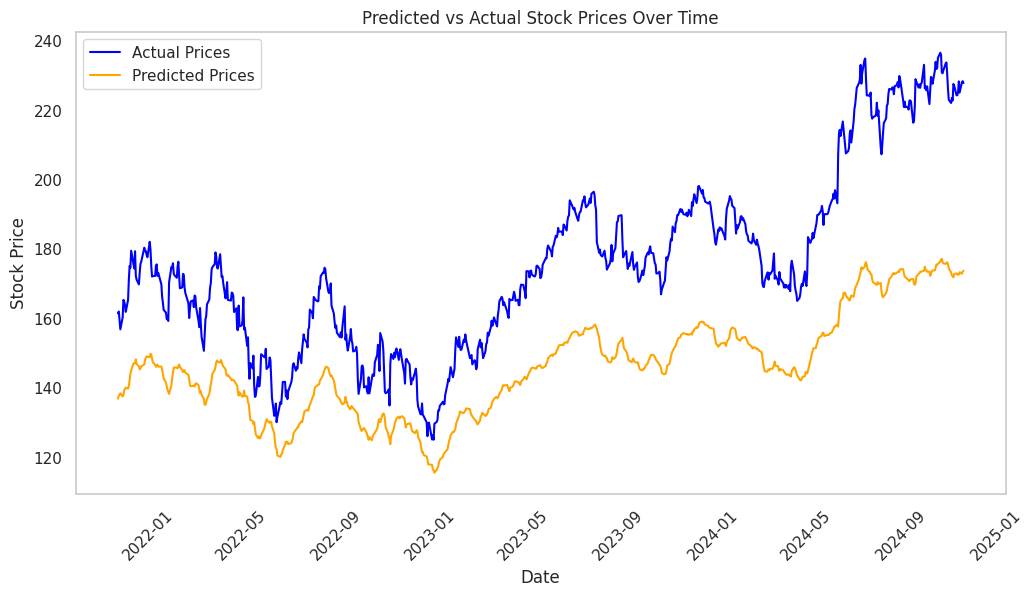

Final Loss: 1001.8848876953125


In [44]:
def plot_predictions_over_time(test_loader, predictions, actuals, test_data, criterion):
    '''
    Inputs:
    - test_loader: DataLoader object containing test data
    - predictions: Tensor containing model predictions
    - actuals: Tensor containing actual target values
    - test_data: DataFrame containing all data
    '''
    # Extract dates from test dataset
    test_dates = test_data['Date'][-len(actuals):].values  # Ensure dates align with test data

    # Plot predicted and actual prices
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, actuals, label="Actual Prices", color="blue")
    plt.plot(test_dates, predictions, label="Predicted Prices", color="orange")
    plt.title("Predicted vs Actual Stock Prices Over Time")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()
    predictions = torch.tensor(predictions)
    actuals = torch.tensor(actuals)

    loss = criterion(predictions, actuals)
    print(f"Final Loss: {loss}")

# Call the plotting function
criterion = torch.nn.MSELoss()
test_data = faang_df[faang_df['Ticker'] == ticker].sort_values('Date')
plot_predictions_over_time(test_loader, predictions, actuals, test_data, criterion)

## 2.3: Long-Term Short-Term (LSTM) Model

Now, we will introduce another type of time-series machine learning model, the Long-Term Short-Term (LSTM) model. This is also a form of deep learning that works similarly to an RNN, but tends to "remember" long term data more effectively. Long-term data is stored in a gate, which is added on to every time-series instance later on down the line. During training, the model decides whether or not individual examples should be included in memory (input gate). Previous states are also removed (forget gate) and added to the prediction (input gate) at each point in time, contributing to the final prediction. This is more effective at including previous entries "long-term" so they contribute to subsequent predictions down the line.

For more details, feel free to visit the lecture slides on Transformers and Time-Varying data.

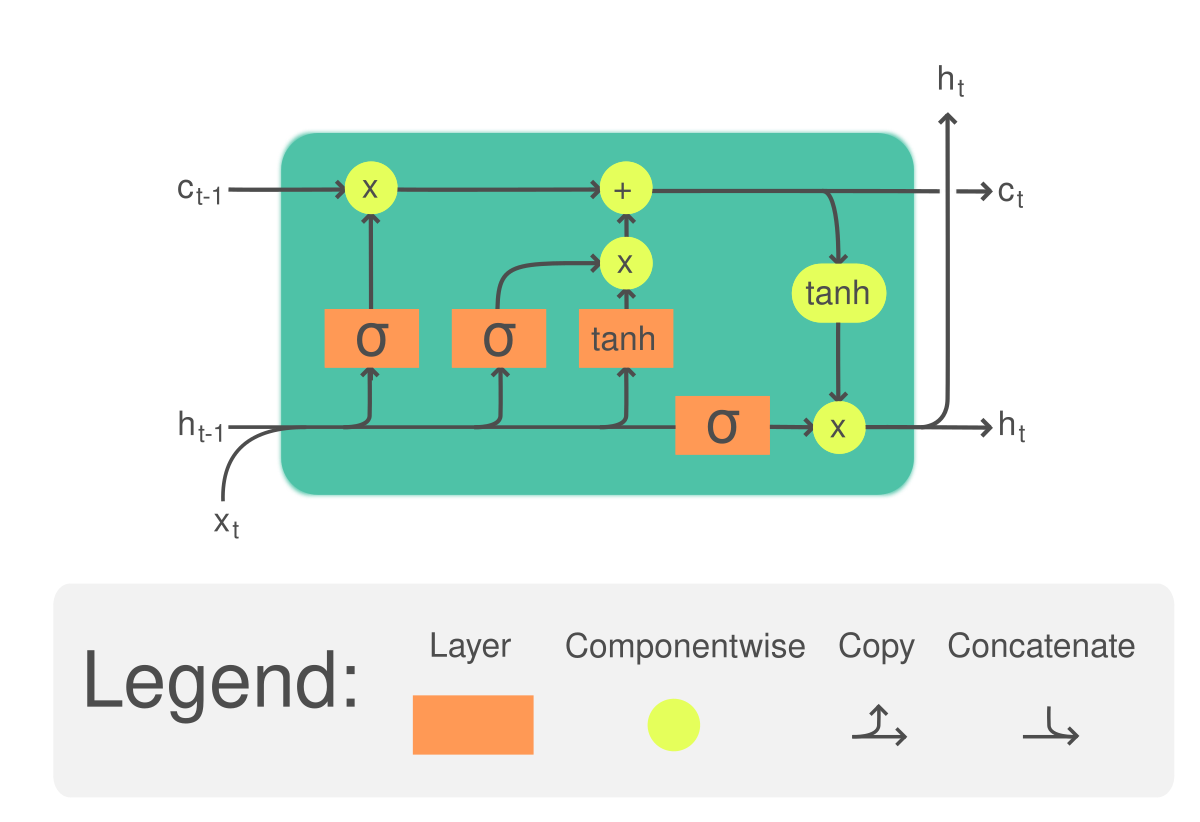

### 2.3.1: Define LSTM Architecture [5 points]

In [ ]:
## TODO: Create a class for building LSTM models
class LSTM(nn.Module):
    # TODO: Create a constructor
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        # TODO: Define stacked LSTM layers

        # TODO: Define a fully connected layer

        # TODO: Create a feed forward method

    def forward(self, x, hidden=None):
        # TODO: Initialize hidden and cell states if not provided

        # TODO: Pass through LSTM layers

        # TODO: Pass the last time step's output through the fully connected layer


In [64]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        '''
        Initialize the LSTM model.

        Inputs:
        - input_size: Number of features in the input data (1 for single time series variable)
        - hidden_size: Number of hidden units in the LSTM
        - output_size: Number of output units (1 for regression)
        - num_layers: Number of LSTM layers (stacked LSTMs)
        '''
        super(LSTM, self).__init__()

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Define a fully connected output layer to map the last LSTM output to the final prediction
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        '''
        Define the forward pass of the LSTM model.

        Inputs:
        - x: Input tensor of shape (batch_size, sequence_length, input_size)
        - hidden: A tuple containing the hidden state and cell state (optional)

        Returns:
        - out: Final output prediction after passing through the LSTM and FC layers
        - (h_n, c_n): Hidden state and cell state for the final time step
        '''
        # Initialize hidden and cell states if not provided
        if hidden is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial hidden state
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Initial cell state
        else:
            h0, c0 = hidden

        # Pass the input through the LSTM layer
        out, (h_n, c_n) = self.lstm(x, (h0, c0))

        # Pass the output of the last time step through the fully connected layer
        out = self.fc(out[:, -1, :])  # We only care about the last time step for the prediction

        return out, (h_n, c_n)

In [65]:
input_size = 1  # For single time series feature (e.g., closing price)
hidden_size = 64  # Number of hidden units in the LSTM
output_size = 1  # Output size (forecasted value for the next time step)
num_layers = 2  # Number of LSTM layers (stacked LSTM)

# Instantiate the LSTM model
model = LSTM(input_size, hidden_size, output_size, num_layers)

In [66]:
model

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [48]:
# Grader Cell
grader.grade('define_lstm', answer = (str(model), input_size, hidden_size, output_size, num_layers))

Correct! You earned 5.0/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3.2: Fit/train LSTM Model [3 points]

Now that the LSTM model has been defined, let's train it on our model.

**TODO:** Complete the `train_model` function, which defines a training loop for us to use in the subsequent parts. You can use the `DataLoader` objects that we previously defined.

**Hints:**
* If you are still confused on training loops, we encourage you to refer to your code for the HW 5 main path. Note that even though we have changed the model architecture from an FCN/CNN to an RNN, `Pytorch` provides the same framework for training all of these algorithms, so we can use a very similarly-structured training loop.
* You will need to decide on appropriate parameters for the model. If you are getting a very poor loss value/losing points on the autograder, consider changing your model parameters.

In [ ]:
## TODO: Train your LSTM model

# TODO: Instantiate criterior (MSE loss), and optimizer (adam, with learning rate 0.001)

# TODO: Train model

In [67]:
def train_model(model, train_loader, criterion, optimizer, epochs=20, device='cuda'):
    '''
    Train the LSTM model.

    Inputs:
    - model: the instantiated LSTM model
    - train_loader: DataLoader containing training data for the model
    - criterion: loss function (e.g., MSELoss)
    - optimizer: optimizer (e.g., Adam)
    - epochs: number of epochs to train the model for
    - device: the device to use for training ('cuda' or 'cpu')

    Returns:
    - loss_list: a list of the training loss for each epoch
    '''
    loss_list = []
    model = model.to(device)  # Move model to the specified device
    criterion = criterion.to(device)  # Move loss function to device
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        running_loss = 0.0
        for i, (x_batch, y_batch) in enumerate(train_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move data to device

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            out, _ = model(x_batch)  # Model returns output (out) and hidden state (we ignore the hidden state)

            # Compute the loss
            loss = criterion(out, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss for this batch
            running_loss += loss.item()

        # Print loss every epoch
        avg_loss = running_loss / len(train_loader)
        loss_list.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    return loss_list

In [56]:
# Grader Cell
grader.grade(test_case_id="lstm_loss", answer=loss_list)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### 2.3.3: Evaluate LSTM Model [4 manually graded points]

**TODO:** Finally, we will evaluate the LSTM model on the test data.
- Use the `evaluate_model` method to evaluate your model on the test data.
- Use the `plot_predictions_over_time` function to generate a plot of the predicted values. The function should plot both the ground truth values and the model prediction on the same pair of axes. Remember to include a figure title, axis titles, and legend in your function.

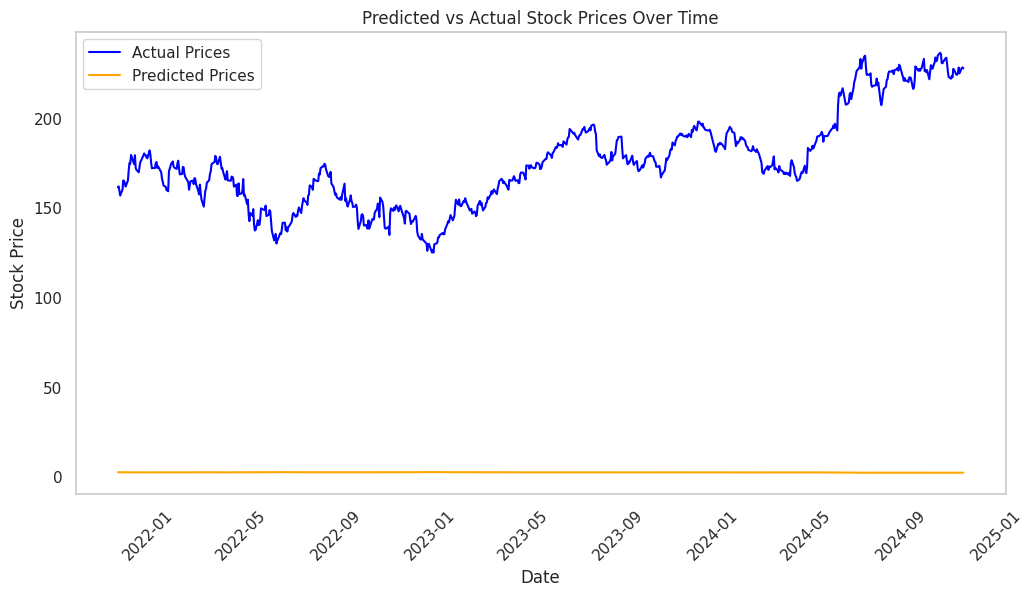

Final Loss: 30662.91015625


In [68]:
predictions, actuals = evaluate_model(model, test_loader, scaler)
criterion = torch.nn.MSELoss()
plot_predictions_over_time(test_loader, predictions, actuals, test_data, criterion)

## 2.4: Reflection (1 manually graded point)

You've now had exposure to traditional time-series models, as well as machine learning time-series analysis tools. Write a brief reflection on your takeaways from using these models in this setting:
* What are some unique challenges associate with time-series data, and how can we overcome these in practice?
* What are some of the advantages/disadvantages of using traditional vs. deep learning methods for time-series analysis?

Working with time-series data presents unique challenges, primarily due to the sequential and autocorrelated nature of the data. Unlike standard datasets, time-series cannot be randomly shuffled, and the order of observations must be preserved. Additionally, concepts like seasonality, trends, and stationarity must be accounted for to build accurate models. Missing data, irregular sampling, and non-stationary behavior can further complicate preprocessing.

Traditional time-series models like the Moving Average (MA) are intuitive, interpretable, and work well on smaller datasets or where the patterns are relatively simple. However, they struggle with capturing complex, non-linear relationships and long-term dependencies. On the other hand, deep learning methods like RNNs and LSTMs can model intricate temporal patterns and dependencies more effectively. These models scale well with data and often yield better performance, but they require more data, computational resources, and careful tuning to avoid overfitting or vanishing gradients.

In practice, a hybrid approach is often valuable—starting with traditional models to establish baselines and moving to deep learning methods when the problem complexity and dataset size justify it.

# **Part 3:** Streaming [10 points]

Description: In this part, you will be given a streaming dataset of FAANG stock prices. Your task is to compute the average volume of each stock over a 5-day window, and then write the results to a memory sink. You will then query the sink to get the results.

This simulates a real-time scenario where you are given a stream of data, and you need to compute some summary statistics on the fly.

You might find these documentations on writeStream for Apache Spark helpful:

https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html
https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.writeStream.html


In [69]:
###### DO NOT EDIT ######
!pip install pyspark

In [70]:
###### DO NOT EDIT ######
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType

In [71]:
###### DO NOT EDIT ######
# Create Spark Session with additional configurations
spark = SparkSession.builder \
    .appName("FAANG Streaming") \
    .config("spark.sql.streaming.checkpointLocation", "/tmp/checkpoint") \
    .getOrCreate()

In [72]:
# TODO: Define schema based on faang_df
schema = StructType([
    StructField("Date", TimestampType(), True),
    StructField("Open", DoubleType(), True),
    StructField("High", DoubleType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Adj Close", DoubleType(), True),
    StructField("Volume", DoubleType(), True),
    StructField("Ticker", StringType(), True)
])

In [73]:
!wget https://storage.googleapis.com/penn-cis5450/faang_part_0.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_1.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_2.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_3.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_4.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_5.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_6.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_7.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_8.csv
!wget https://storage.googleapis.com/penn-cis5450/faang_part_9.csv

--2025-04-26 00:05:51--  https://storage.googleapis.com/penn-cis5450/faang_part_0.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251204 (245K) [text/csv]
Saving to: ‘faang_part_0.csv’

faang_part_0.csv    100%[===================>] 245.32K  --.-KB/s    in 0.002s  

2025-04-26 00:05:51 (112 MB/s) - ‘faang_part_0.csv’ saved [251204/251204]

--2025-04-26 00:05:51--  https://storage.googleapis.com/penn-cis5450/faang_part_1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 108.177.98.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236487 (231K) [text/csv]
Saving to: ‘faang_part_1.csv’

faang_part_1.csv    100%[===========

In [74]:
!mkdir stream_data
!mv *.csv stream_data

In [75]:
# Read streaming data with explicit schema and more robust options
faangStreamDF = spark.readStream \
    .format("csv") \
    .option("header", "true") \
    .option("sep", ",") \
    .option("maxFilesPerTrigger", 1) \
    .schema(schema) \
    .load("/content/stream_data/")

In [84]:
from pyspark.sql.functions import to_timestamp, unix_timestamp, from_unixtime

# Convert the Date column to a timestamp format (if needed)
faangStreamDF = faangStreamDF.withColumn(
    "Date",
    from_unixtime(unix_timestamp(col("Date"), "yyyy-MM-dd"))
)

In [ ]:
faangStreamDF = faangStreamDF.withColumn("Date", to_timestamp(col("Date"), "yyyy-MM-dd"))

In [86]:
# TODO: Complete windowed aggregation
avgVolumeDF = faangStreamDF \
    .withWatermark("Date", "5 days") \
    .groupBy(
        window(col("Date"), "5 days", "1 day"),  # 5-day window sliding by 1 day
        col("Ticker")
    ) \
    .agg(avg("Volume").alias("avg_volume")) \
    .select("window", "Ticker", "avg_volume")

AnalysisException: [EVENT_TIME_IS_NOT_ON_TIMESTAMP_TYPE] The event time `Date` has the invalid type "STRING", but expected "TIMESTAMP".;
EventTimeWatermark Date#20449: string, 5 days
+- Project [from_unixtime(unix_timestamp(Date#16, yyyy-MM-dd, Some(Etc/UTC), false), yyyy-MM-dd HH:mm:ss, Some(Etc/UTC)) AS Date#20449, Open#1, High#2, Low#3, Close#4, Adj Close#5, Volume#6, Ticker#7]
   +- Project [to_timestamp(Date#0, Some(yyyy-MM-dd), TimestampType, Some(Etc/UTC), false) AS Date#16, Open#1, High#2, Low#3, Close#4, Adj Close#5, Volume#6, Ticker#7]
      +- StreamingRelation DataSource(org.apache.spark.sql.SparkSession@3e4a954e,csv,List(),Some(StructType(StructField(Date,TimestampType,true),StructField(Open,DoubleType,true),StructField(High,DoubleType,true),StructField(Low,DoubleType,true),StructField(Close,DoubleType,true),StructField(Adj Close,DoubleType,true),StructField(Volume,DoubleType,true),StructField(Ticker,StringType,true))),List(),None,Map(header -> true, sep -> ,, maxFilesPerTrigger -> 1, path -> /content/stream_data/),None), FileSource[/content/stream_data/], [Date#0, Open#1, High#2, Low#3, Close#4, Adj Close#5, Volume#6, Ticker#7]


In [87]:
from pyspark.sql.functions import to_timestamp, col

# Ensure 'Date' is read as timestamp during the initial DataFrame creation
faangStreamDF = spark.readStream \
    .format("csv") \
    .option("header", "true") \
    .option("sep", ",") \
    .option("maxFilesPerTrigger", 1) \
    .schema(schema) \
    .load("/content/stream_data/") \
    .withColumn("Date", to_timestamp(col("Date"), "yyyy-MM-dd"))  # Convert here

# Now you can apply withWatermark
avgVolumeDF = faangStreamDF \
    .withWatermark("Date", "5 days") \
    .groupBy(
        window(col("Date"), "5 days", "1 day"),
        col("Ticker")
    ) \
    .agg(avg("Volume").alias("avg_volume")) \
    .select("window", "Ticker", "avg_volume")

In [88]:
# TODO: Write to memory sink with complete output mode
query = avgVolumeDF.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("avg_volume_table") \
    .start()

IllegalArgumentException: Cannot start query with name avg_volume_table as a query with that name is already active in this SparkSession

In [89]:
# Stop the existing query if it's active
if query and query.isActive:
    query.stop()

# Write to memory sink with complete output mode
query = avgVolumeDF.writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("avg_volume_table") \
    .start()

In [ ]:
###### EDITED ########
# Wait for the query to start processing
query.awaitTermination(15)  # Wait for 15 seconds to ensure data is processed

# Adding a slight delay before showing results to ensure processing is completed
import time
time.sleep(25)  # Add a delay before calling show()

# Show results
# Change the table name in the SQL query to 'avg_volume_table'
faang_summary_df = spark.sql("SELECT * FROM avg_volume_table ORDER BY Ticker, window").toPandas().reset_index(drop=True)
faang_summary_df.head(20)

In [94]:
###### DO NOT EDIT ########
# Wait for the query to start processing
query.awaitTermination(15)  # Wait for 15 seconds to ensure data is processed

# Adding a slight delay before showing results to ensure processing is completed
import time
time.sleep(25)  # Add a delay before calling show()

# Show results
faang_summary_df = spark.sql("SELECT * FROM faang_volume_summary ORDER BY Ticker, window").toPandas().reset_index(drop=True)
faang_summary_df.head(20)

AnalysisException: [TABLE_OR_VIEW_NOT_FOUND] The table or view `faang_volume_summary` cannot be found. Verify the spelling and correctness of the schema and catalog.
If you did not qualify the name with a schema, verify the current_schema() output, or qualify the name with the correct schema and catalog.
To tolerate the error on drop use DROP VIEW IF EXISTS or DROP TABLE IF EXISTS.; line 1 pos 14;
'Sort ['Ticker ASC NULLS FIRST, 'window ASC NULLS FIRST], true
+- 'Project [*]
   +- 'UnresolvedRelation [faang_volume_summary], [], false


In [91]:
print(len(faang_summary_df))

0


In [92]:
faang_summary_pandas = faang_summary_df.copy()
faang_summary_pandas['window'] = faang_summary_pandas['window'].apply(lambda x: str(x))

In [93]:
# Grader Cell
grader.grade(test_case_id = "streaming_test", answer = (faang_summary_pandas.head(20), len(faang_summary_df)))

You earned 3/10 points.

Too few rowsDon't worry, you can re-submit and we will keep only your latest score.


# Submission Guidelines:

Congratulations on finishing this part of HW 5! When you are ready to submit on Gradescope, please submit a .py and .ipynb of this notebook.

**A few reminders:**
* **Double check** that you have the correct PennID (all numbers) in the autograder.

* **Triple check** that you fulfilled all the requirements mentioned in the beginning of the notebook.

* You must submit your notebook to receive credit. Post any issues with submission on Ed and make sure to keep in mind the late day policy.

* After you submit your code, the teaching staff will manually grade your Colab notebook in order to validate the correctness of your code.

* Please remember to follow best practices for graphs and HW assignment submission as stated on Ed.